# SpaceNet on AWS


SpaceNet is a corpus of commercial satellite imagery and labeled training data to use for machine learning research. The dataset is currently hosted as an Amazon Web Services (AWS) Public Dataset. This notebook will apply a custom MXNet-based U-Net algorithm to build a neural network that will automatically detect buildings in the dataset using machine learning. 

In [ ]:
# Only execute when first running the notebook
!conda install -c conda-forge shapely -y
!conda install -c conda-forge tifffile -y

In [ ]:
!aws s3 cp s3://wwps-sagemaker-workshop/spacenet/utils . --recursive

In [3]:
import sagemaker
from sagemaker.mxnet import MXNet, MXNetModel
from sagemaker import get_execution_role
import pandas as pd
import cv2
from shapely.wkt import loads as wkt_loads
from shapely.geometry import Polygon
import os
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
import shapely.geometry
import imageio
import subprocess
import time

%matplotlib inline

sagemaker_session = sagemaker.Session()

In [4]:
import boto3
from io import BytesIO

s3 = boto3.resource('s3')
in_bucket = 'wwps-sagemaker-workshop'
prefix = 'spacenet/dataset/'

def load_training_image(bucket,image_key):
    key = prefix + image_key
    return tiff.imread(BytesIO(s3.Object(bucket,key).get()['Body'].read()))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


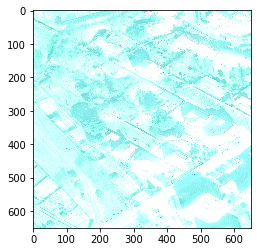

In [5]:
#Load RGB bands and transpose image shape

test = load_training_image(in_bucket,'AOI_3_Paris_Train/RGB-PanSharpen/RGB-PanSharpen_AOI_3_Paris_img100.tif')
plt.imshow(test)


The image looks weird because its actually an 11-bit image stored in 16 bit integers. You can try to figure out what that means, or you can just run the next cell which will make everything look better

In [6]:
def scale_bands(img, lower_pct = 1, upper_pct = 99):
    """
    Rescale the bands of a multichannel image for display
    """
    # Loop through the image bands, rescaling each one
    img_scaled = np.zeros(img.shape, np.uint8)
    
    for i in range(img.shape[2]):
        
        band = img[:, :, i]
        
        # Pick out the lower and upper percentiles
        lower, upper = np.percentile(band, [lower_pct, upper_pct])
        
        # Normalize the band
        band = (band - lower) / (upper - lower) * 255
        
        # Clip the high and low values, and cast to uint8
        img_scaled[:, :, i] = np.clip(band, 0, 255).astype(np.uint8)
        
    return img_scaled

(650, 650, 3)


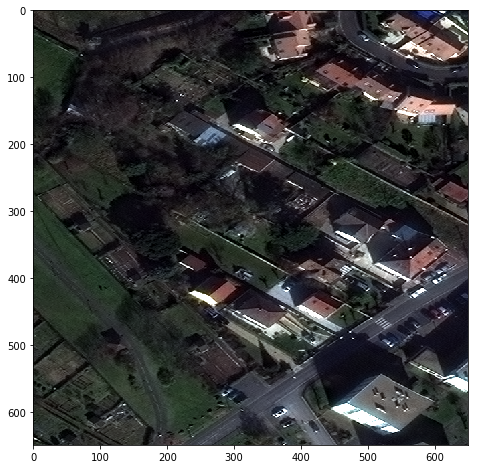

In [7]:
# Plot the rescaled image
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(scale_bands(test))
print(test.shape)

# Create Masks for our Training Dataset

We will use the SpaceNet Utilities to create masks from the geojson data

In [8]:
def _get_polygon_list(wkt_list_pandas, imageId):
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    poly_def = df_image.PolygonWKT_Pix
    polygonList = None
    polygonList = [wkt_loads(x) for x in poly_def]
    return polygonList, poly_def


def _get_and_convert_contours(polygonList, raster_img_size, poly_def):
    perim_list = []
    interior_list = []
    if len(poly_def) < 2:
        return None
    for k in range(len(poly_def)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = np.array(perim[:,:-1]).astype(int)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
#            interior_c = _convert_coordinates_to_raster(interior, raster_img_size)
            interior_list.append(np.int32(interior[:,:-1]))
    return perim_list,interior_list


def _plot_mask_from_contours(raster_img_size, ext_pts, int_pts, class_value = 1):
    img_mask = np.zeros(raster_img_size,np.uint8)
    cv2.fillPoly(img_mask, np.asarray(ext_pts),1)
    cv2.fillPoly(img_mask, np.asarray(int_pts),0)
    return img_mask

def generate_mask_for_image_and_class(raster_size, imageId, wkt_list_pandas):
    polygon_list, poly_def = _get_polygon_list(wkt_list_pandas,imageId)
    if len(polygon_list) < 2:
        mask = np.zeros(raster_size,np.uint8)
        return mask
    else:
        ext, inte = _get_and_convert_contours(polygon_list,raster_size, poly_def)
        mask = _plot_mask_from_contours(raster_size,ext, inte,1)
        return mask

In [9]:
df = pd.read_csv(BytesIO(s3.Object(in_bucket, prefix+'AOI_3_Paris_Train/summaryData/AOI_3_Paris_Train_Building_Solutions.csv').get()['Body'].read()))

def get_image_id(image_file_name):
    return image_file_name[48:-4]

def list_images_in_bucket():
    images = []
    s3client = boto3.client('s3')
    s3_list_objects_resp = s3client.list_objects_v2(Bucket=in_bucket,Prefix=prefix+'AOI_3_Paris_Train/RGB-PanSharpen')
    for obj in s3_list_objects_resp['Contents']:
        key = obj['Key'][17:]
        if key.lower().endswith('.tif'):
            images.append(key)
    return images


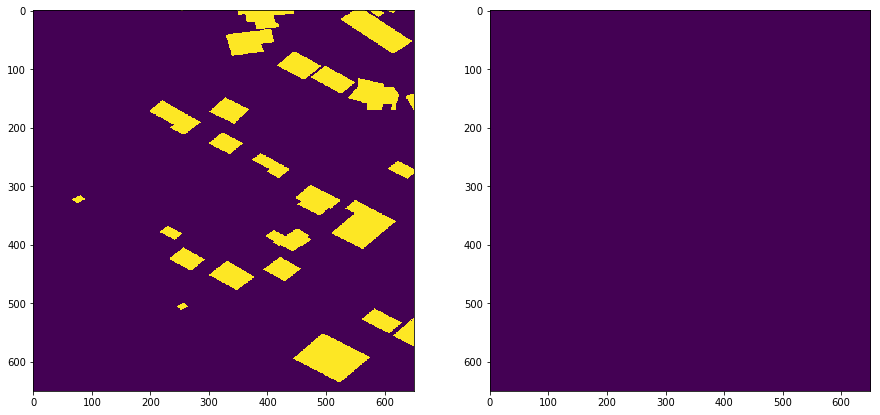

In [10]:
# Display example masks generated from ground truth polygons
plt.figure(figsize=(15, 15))
plt.subplot(121)
example_mask = generate_mask_for_image_and_class((650,650),'AOI_3_Paris_img100',df)
plt.imshow(example_mask)
plt.subplot(122)
example_mask = generate_mask_for_image_and_class((650,650),'AOI_3_Paris_img10',df)
plt.imshow(example_mask)

In [11]:
def fraction_nonzero(msk):
    """Returns the ratio of non-zero values in an array compared to the overall array size"""
    return 1.0 * np.count_nonzero(msk) / msk.size

def apply_random_transform(img,msk):
    """Randomly flip, rotate, or transpose the input arrays."""
    
    # Pick a random transformation, if the input doesn't have a square
    # shape limit the options to transformations that do not alter the
    # width, height
    selected_transform = np.random.randint(0,8)
    if img.shape[0] != img.shape[1]:
        selected_transform = np.random.randint(0,3)
        
    if selected_transform == 1:
        # Vertical Flip
        img = img[::-1,:,:]
        msk = msk[::-1,:,:]
    elif selected_transform == 2:
        # Horizontal Flip
        img = img[:,::-1,:]
        msk = msk[:,::-1,:]
    elif selected_transform == 3:
        # Rotate 180
        img = np.rot90(img, 2)
        msk = np.rot90(msk, 2)
    elif selected_transform == 4:
        # Transpose
        img = img.transpose([1,0,2])
        msk = msk.transpose([1,0,2])
    elif selected_transform == 5:
        # Rotate 90
        img = np.rot90(img, 1)
        msk = np.rot90(msk, 1)
    elif selected_transform == 6:
        # Rotate 270
        img = np.rot90(img, 3)
        msk = np.rot90(msk, 3)
    else:
        pass

    return img,msk


def create_image_crops(tiff_images, ground_truth, min_masked=0.1, tile_size=256,stride=100,num_variations=1):
    """Create pairs of images and masks by sampling regions from larger images and generated ground truth masks.
    
    This function creates paired lists of images and masks by sampling tiles from the input images. The number
    of image mask pairs created per image depends on the ground truth data. A tile will be discarded if the ratio
    of masked pixels to the overall tile size is less than the minimum threshold provided (this eliminates training
    examples that do not have significant regions to learn). This elimination will reduce the number of 
    examples in a training set you can choose to create several variations of each tile by applying random flips and
    rotations. The number of examples per image can also be increased by decreasing the sampling stride. Doing so 
    will result in examples with more overlap which will be mitigated to some degree by the application of 
    random transforms.
    
    Note that this version of the function loads the images directly from S3 and then generates the masks for 
    these images on the fly (see generate_mask_for_image_and_class(...) )
    Keyword arguments:
    min_masked     -- the fraction of an image that must have a non-zero mask to be included (default 0.1)
    tile_size      -- the size of the region to sample (default 256)
    stride         -- the distance between sampled regions (default 100)
    num_variations -- the number of randomly transformed variants for each region (default 1) 
    
    """
    example_images = []
    truth_masks = []
    for image_file_name in tiff_images:

        
        #print('Processing: ' + image_file_name)
        
        # Load the image from S3 and ensure it exists
        image_full = load_training_image(in_bucket, image_file_name)
        
        # Check to ensure that we can get at least one tile from this image
        height = image_full.shape[0]
        width = image_full.shape[1]
        if height < tile_size or width < tile_size:
            continue
        
        # Generate a mask for this image from the ground truth data
        mask_full = generate_mask_for_image_and_class((height,width), get_image_id(image_file_name), ground_truth)
            
        for row_offset in range(0, height-tile_size, stride):
            for column_offset in range(0, width-tile_size, stride): 
                
                row_start = row_offset
                row_end = row_start + tile_size
                column_start = column_offset
                column_end = column_start + tile_size
                
                mask_tile = mask_full[row_start:row_end, column_start:column_end]
                
                
                if fraction_nonzero(mask_tile) >= min_masked:
                    mask_tile = np.expand_dims(mask_tile, axis=0)
                    image_tile = image_full[row_start:row_end, column_start:column_end, :]
                    image_tile = np.transpose(image_tile, (2, 0, 1))
                    for i in range(0,num_variations):
                        image_tile,mask_tile = apply_random_transform(image_tile,mask_tile)
                        example_images.append(image_tile)
                        truth_masks.append(mask_tile)
                    

    return example_images, truth_masks

In [13]:
#Note we are only training on the first 200 images! This is just to save time for the workshop
tiff_images = list_images_in_bucket()
img, mask = create_image_crops(tiff_images[:200],df,min_masked=0.2,num_variations=2)
print('There are ' + str(len(img)) + ' examples in our dataset.')
if len(img) != len(mask):
    print('Something went horribly wrong!!! We have a different number of lables than we have examples.')   

There are 994 examples in our dataset.


# Split dataset

Now that we know that the code is running - lets train over the entire dataset. Right now the results look questionable but we only had two training images! However, it is generally much easier to experiement on the smaller dataset and confirm that your transformations and code are running properly.

To begin, we are going to read in an object from S3 - generate a mask, and then store it in a new folder called "masks"

In [15]:
if not os.path.exists('./arrays/'):
            os.makedirs('./arrays/')

split_index = int(len(img)*0.7)
sess_bucket = sagemaker_session.default_bucket()
img = np.array(img)
mask = np.array(mask)

np.save('arrays/train_X_crops.npy', img[:split_index, :, :, :])
np.save('arrays/train_Y_crops.npy', mask[:split_index, :, :, :])
np.save('arrays/validation_X_crops.npy', img[split_index:, :, :, :])
np.save('arrays/validation_Y_crops.npy', mask[split_index:, :, :, :])

In [16]:
inputs = sagemaker_session.upload_data(path='arrays/', key_prefix='full-seg')

### Configure Training Job

We will run custom code on a p2 instance type. Right now our model will be sub-optimal but thats okay! We will tune it in the next iteration.

In [17]:
role = get_execution_role()

In [18]:
sagemaker_net = MXNet("color_segmentation.py", 
                  role=role, 
                  train_instance_count=1, 
                  train_instance_type="ml.p3.8xlarge",
                  sagemaker_session=sagemaker_session,
                  hyperparameters={
                                 'data_shape': (3, 256, 256),
                                 'batch_size': 8,
                                 'epochs': 25,
                                 'learning_rate': 1E-3, 
                                 'num_gpus': 4,
                                  })

sagemaker_net.fit(inputs)

No framework_version specified, defaulting to version 1.2. This is not the latest supported version. If you would like to use version 1.3, please add framework_version=1.3 to your constructor.


2019-05-22 19:07:11 Starting - Starting the training job...
2019-05-22 19:07:13 Starting - Launching requested ML instances......
2019-05-22 19:08:23 Starting - Preparing the instances for training......
2019-05-22 19:09:36 Downloading - Downloading input data
2019-05-22 19:09:36 Training - Downloading the training image.....
2019-05-22 19:10:19,235 INFO - root - running container entrypoint
2019-05-22 19:10:19,235 INFO - root - starting train task
2019-05-22 19:10:19,293 INFO - container_support.training - Training starting
2019-05-22 19:10:20,476 WARNING - mxnet_container.train - #033This required structure for training scripts will be deprecated with the next major release of MXNet images. The train() function will no longer be required; instead the training script must be able to be run as a standalone script. For more information, see https://github.com/aws/sagemaker-python-sdk/tree/master/src/sagemaker/mxnet#updating-your-mxnet-training-script.#033
2019-05-22 19:10:21,110 INFO - 

In [22]:
sagemaker_predictor = sagemaker_net.deploy(initial_instance_count=1, instance_type='ml.m4.4xlarge')

Using already existing model: sagemaker-mxnet-2019-05-22-19-07-11-170


-----------------------------------------------------------------------------------------------------!

In [23]:
import mxnet as mx

test_iter = mx.io.NDArrayIter(data = img[92:93, :, :, :], label=mask[92:93, :, :, :], batch_size=1, shuffle=False)
batch = next(test_iter)

data = batch.data[0]
label = batch.label[0]
#response = sagemaker_predictor.predict(data.asnumpy().tolist())
response = sagemaker_predictor.predict(data.asnumpy())
output = np.array(response[0])
print(output.shape)
print(label.shape)

(1, 256, 256)
(1, 1, 256, 256)


In [ ]:
def post_process_mask(label, p=0.5):
    return (np.where(label > p, 1, 0)).astype('uint8')

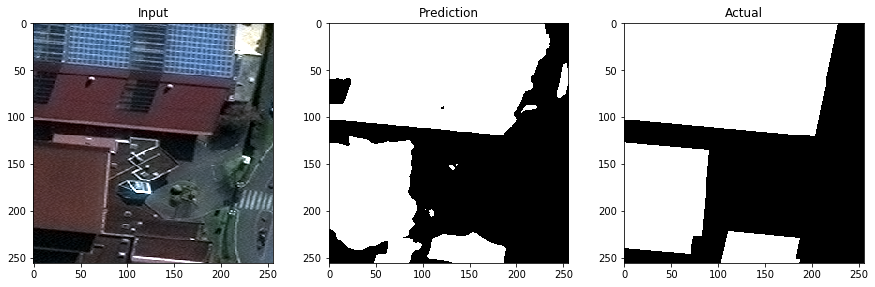

In [24]:
width = 15
height = 15
plt.figure(figsize=(width, height))
plt.subplot(331)
plt.title('Input')
plt.imshow(scale_bands(np.transpose(data.asnumpy()[0], (1,2,0))))
plt.subplot(332)
plt.title('Prediction')
plt.imshow(post_process_mask(output[0], p=0.9), cmap=plt.cm.gray)
plt.subplot(333)
plt.title('Actual')
plt.imshow(label[0][0].asnumpy(), cmap=plt.cm.gray)

### Disaster Response Testing
Testing on Hurricane Maria Data

In [25]:
test_crops = np.load('maria_after_chips.npy')
print(test_crops.shape)
test_iter = mx.io.NDArrayIter(data = test_crops[351:352, :, :, :], batch_size=1, shuffle=False)
batch = next(test_iter)

data = batch.data[0]
print(data.shape)
#response = sagemaker_predictor.predict(data.asnumpy().tolist())
response = sagemaker_predictor.predict(data.asnumpy())
output = np.array(response[0])

(5776, 3, 256, 256)
(1, 3, 256, 256)


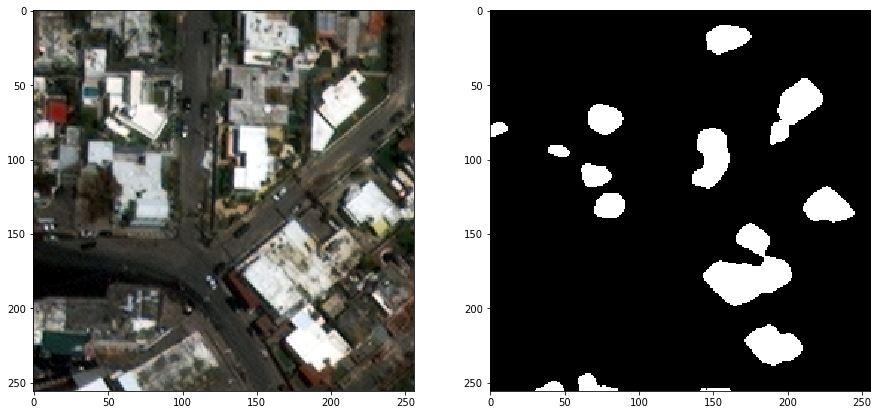

In [26]:
# Display example masks generated from ground truth polygons
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(scale_bands(np.transpose(data.asnumpy()[0], (1,2,0))))
plt.subplot(122)
plt.imshow(post_process_mask(output[0], p=0.1), cmap=plt.cm.gray)

In [29]:
import cv2 as cv

def smooth(img, filter_type):
    if filter_type == "mean":
        return cv.blur(img, (5,5))
    if filter_type == "gaussian":
        return cv.GaussianBlur(img, (5,5), 0)
    if filter_type == "median":
        return cv.medianBlur(img, 5)
    else:
        return cv.bilateralFilter(img, 9, 75, 75)
    
def contrast(img, alpha=1.3, beta=40):
    return cv.convertScaleAbs(img, alpha=alpha, beta=beta)

def gamma(img, gamma=0.8):
    lookUpTable = np.empty((1,256), np.uint8)
    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
    
    res = cv.LUT(img, lookUpTable)
    return res

def detect_veg(img):
    # convert to grayscale
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

    # threshold to convert to binary image
    ret, thresh = cv.threshold(gray,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

    # erode image to isolate the sure foreground
    kernel = np.ones((3,3),np.uint8)
    opening = cv.morphologyEx(thresh,cv.MORPH_OPEN, kernel, iterations=3)

    # get the median pixel value (should be background)
    mode = img.mean(axis=0).mean(axis=0)

    # replace the foreground (trees) with the median pixel
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            # if it's white in the eroded image, then it's vegetation
            if opening[i,j] == 255:
                # set to black
                img[i,j] = mode

    return img

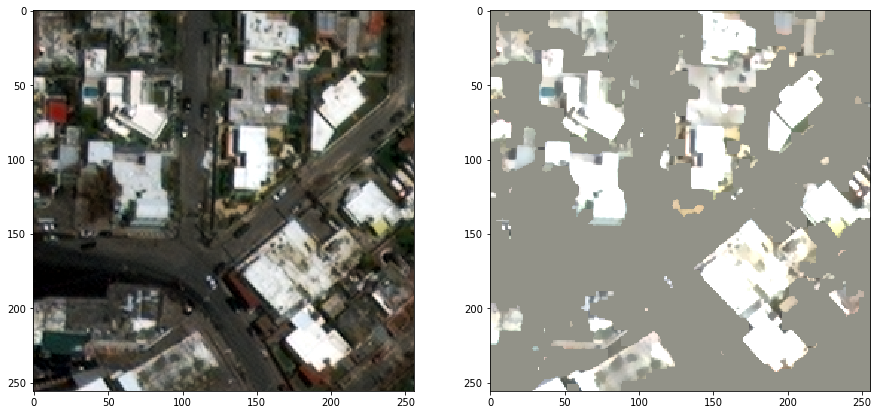

In [30]:
new = scale_bands(np.transpose(data.asnumpy()[0], (1,2,0)))
smoothed = smooth(new, 'bilateral filter')
con = contrast(smoothed, 1.3, 40)
gam = detect_veg(con)

# Display example masks generated from ground truth polygons
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(scale_bands(np.transpose(data.asnumpy()[0], (1,2,0))))
plt.subplot(122)
plt.imshow(gam)

In [31]:
gam2 = np.transpose(gam, (2, 0, 1))
gam2 = np.expand_dims(gam2, axis=0)
print(gam2.shape)

(1, 3, 256, 256)


In [32]:
test_iter = mx.io.NDArrayIter(data = gam2, batch_size=1, shuffle=False)
batch = next(test_iter)

data = batch.data[0]
print(data.shape)
#response = sagemaker_predictor.predict(data.asnumpy().tolist())
response = sagemaker_predictor.predict(data.asnumpy())
output = np.array(response[0])

(1, 3, 256, 256)


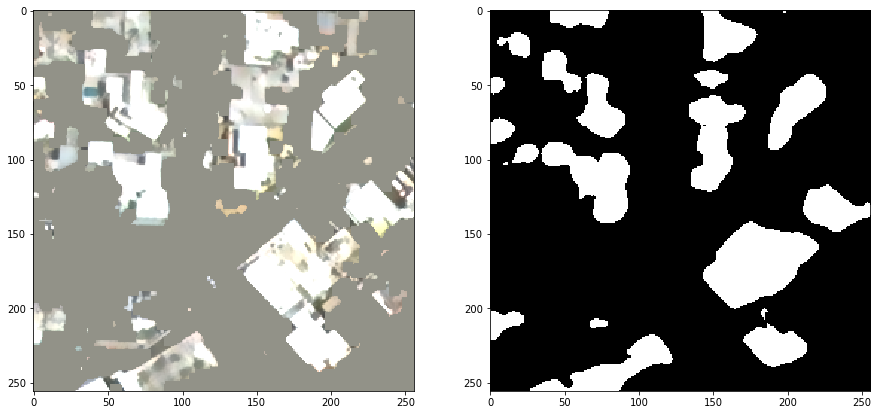

In [33]:
# Display example masks generated from ground truth polygons
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.imshow(gam)
plt.subplot(122)
plt.imshow(post_process_mask(output[0], 0.9), cmap=plt.cm.gray)